## osモジュール読み込み

In [4]:
import os

# 現在の作業ディレクトリを確認
print(os.getcwd())

/Users/chise1/Desktop/Portfolio/Python/MeCab2


## 解析の流れ（前処理→特徴量変換→学習モデル）
##### 1. データ読む：pandasでCSV読み込み
##### 2. トークン化：MeCabで日本語を分割
##### 3. 数値化：TfidVectorrizerでTF-IDFベクトルへ
##### 4. 学習：LogisticRegressionで学習
##### 5. 評価：classification_report, confusion_matrixで性能を見る
##### 6. 可視化：seaborn + matplotlibで混同行列や重要語の棒グラフを作成
##### 7. 交差検証：cross_val_scoreで交差検証を自動実行
### これらを行うためのライブラリを読み込む

## ライブラリの読み込み

In [8]:
import MeCab # MeCab：文章を『単語』や『品詞』に分割
import re    # re：正規表示ライブラリ、テキストの前処理（余分な空白の削除、記号の削除、パターン置換etc.）
import pandas as pd # Pandas：データを扱うためのツール
import numpy as np  # Numpy：数値計算のための多次元配列ライブラリ
from sklearn.model_selection import train_test_split, cross_val_score # 学習用データとテスト用データに分割、交差検証で汎化性能を測るため『cross_val_score』使用
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## CSVファイルの読み込み

In [10]:
df = pd.read_csv("data/demo_movie_reviews_ja_30_posheavy.csv")  # label（0/1） 高評価：1, 低評価：0

## MeCab（文章を単語や形態素に分割）

In [12]:
tagger = MeCab.Tagger("")  # -Owakati は使わない（『単語だけ』でなく品詞などの形態素情報も取りたいから）
tagger.parse("")           # PythonのGC対策（最初に空文字を一度解析して、内部状態を初期化＆安定化）

# 除外したい品詞や単語を指定
stop_pos = {"記号", "助詞", "助動詞", "連体詞", "接続詞", "感動詞", "フィラー"} # pos = part of speech：品詞
stop_words = {"する", "ある", "いる", "なる"}  # words = 単語
# 適宜拡張

def mecab_tokenize(text: str): # 文字列を入力すると、MeCabで分かち書きした単語リストを返す関数
    text = re.sub(r"\s+", "", str(text)) # 空白を消す
    node = tagger.parseToNode(text) # MeCabで形態素解析を開始
    tokens = [] # 空のリストを用意。この中に『必要な単語』入れていく
    while node: # 文章の終わりまで、単語を1つずつ取り出すというループ
        surface = node.surface # 実際の単語の文字を取り出す
        feats = node.feature.split(",") # 形態素情報（品詞などの情報）をカンマで分割してリスト化
        pos = feats[0] if feats else "" # 品詞の中の大分類（最初の要素）を取り出す

        # 条件に合う単語だけ残す
        if surface and pos not in stop_pos and surface not in stop_words:
            tokens.append(surface) # 上の条件が当てはまるもの（単語）だけtokensのリストに追加
        node = node.next           # 次の単語に進むを繰り返し最後まの単語までチェック
    return tokens # whileループが終わったら、残す単語をリストを返す

## Pipeline：TF-IDF → ロジスティック回帰
### Pipeline：『テキストの前処理→特徴量変換→学習モデル』

In [31]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer = mecab_tokenize, # "tfidf", TfidfVectorizer()：TF-IDFベクトル化
                              token_pattern = None,       # カスタムトークナイザ使用時はNone（※自作のtokenizer使用設定）
                              ngram_range = (1,2),        # 単語1つ（unigram）と単語2つ（bigram）の両方を特徴に使用
                              min_df = 1,                 # 1回以上出た単語は特徴に含める（※今回は小規模データなので低めに設定）
                              max_df = 0.95)),            # テキスト全体の95%以上出る『頻出単語』は除外
    ("clf", LogisticRegression(max_iter = 1000, class_weight = "balanced"))  # "clf", LogisticRegression()：ロジスティック回帰部分
    # max_iter：学習の繰り返し海図宇野上限を増やし、収束しやすいように設定（デフォルトは100）
    # class_weight = "balanced"：クラスの出現数に応じて自動的に重み付け（高評価が多く、低評価が少ないようなデータの不均衡を補正）
])

## 学習・評価

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         3
           1     0.6250    0.8333    0.7143         6

    accuracy                         0.5556         9
   macro avg     0.3125    0.4167    0.3571         9
weighted avg     0.4167    0.5556    0.4762         9



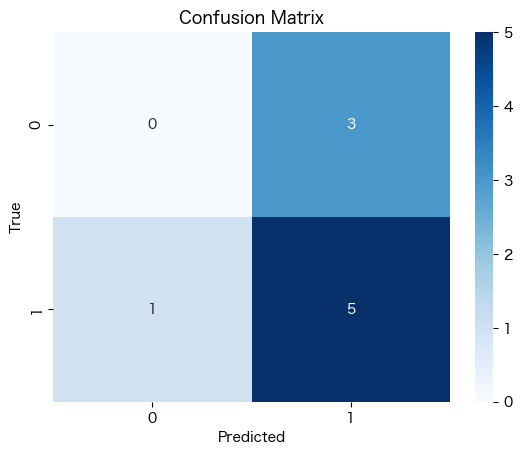

In [34]:
X_train, X_test, y_train, y_test = train_test_split( # データ分割：データを『学習用』と『評価用』に分ける
    df["text"], df["label"], test_size = 0.3, random_state = 42, stratify = df["label"]
)
pipeline.fit(X_train, y_train)    # 学習：学習データを使ってモデルを訓練する（『MeCab → TF_IDF → ロジスティック回帰』が行われる）
y_pred = pipeline.predict(X_test) # 予測：訓練済みモデルにテストデータを入れて『予測ラベル』を出す

print(classification_report(y_test, y_pred, digits = 4)) # 数値評価：precision（適合率）, recall（再現性）, F1（バランス指標）, support（件数） 
# digits：小数点以下4桁まで表示
cm = confusion_matrix(y_test, y_pred) # 混同行列を作成（正解と予測の対応表作成）
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues") # 混同行列をヒートマップとして可視化
# annot = True：数字をマス目に表示
# fmt = "d"：整数で表示
# cmap = "Blues"：青系のカラーマップ
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

## 次の工程で日本語が文字化けしないようにフォントを指定

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Hiragino Sans"  # Mac標準の日本語フォント

## 重要語の可視化

Positiveに寄与: [('し', 0.28348464984295413), ('的', 0.21432508662339866), ('感動', 0.16670900268427022), ('映像', 0.1665609421136454), ('観', 0.16103323332784372), ('残る', 0.16070079188246872), ('い', 0.15172858053942095), ('笑い', 0.11249380619687435), ('バランス 良い', 0.11249380619687435), ('良い', 0.11249380619687435)]
Negativeに寄与: [('外れ 残念', -0.27006790630622723), ('期待 外れ', -0.27006790630622723), ('外れ', -0.27006790630622723), ('残念', -0.27006790630622723), ('移入 でき', -0.2025714782903545), ('大げさ', -0.2025714782903545), ('大げさ 感情', -0.2025714782903545), ('移入', -0.2025714782903545), ('感情 移入', -0.2025714782903545), ('感情', -0.2025714782903545)]


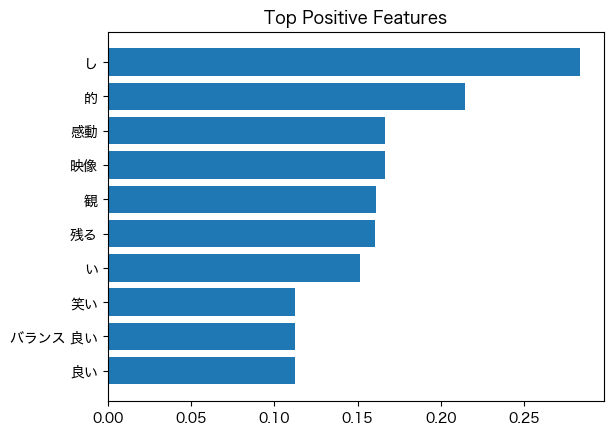

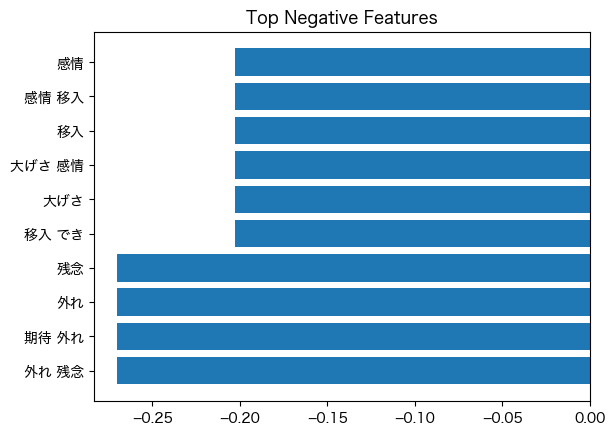

In [23]:
# pipelineの中からそれぞれの部品を取り出し
vec = pipeline.named_steps["tfidf"] # vec：TF-IDF変換器
clf = pipeline.named_steps["clf"]   # clf：ロジスティック回帰モデル
feature_names = np.array(vec.get_feature_names_out()) # TF-IDFで使用している単語（特徴量）のリストを取り出し
coefs = clf.coef_[0] # ロジスティック回帰で学習された各単語の重み（係数）を取り出す

topk = 10
# np.argsort(coefs)：係数を小さい順に並べたインデックス
pos_idx = np.argsort(coefs)[-topk:][::-1]  # positive寄与
neg_idx = np.argsort(coefs)[:topk]         # negative寄与

print("Positiveに寄与:", list(zip(feature_names[pos_idx], coefs[pos_idx])))
print("Negativeに寄与:", list(zip(feature_names[neg_idx], coefs[neg_idx])))

# 棒グラフで可視化
plt.barh(feature_names[pos_idx][::-1], coefs[pos_idx][::-1]); plt.title("Top Positive Features"); plt.show() # 高評価に効いた単語TOP10
plt.barh(feature_names[neg_idx], coefs[neg_idx]); plt.title("Top Negative Features"); plt.show()             # 低評価に効いた単語TOP10

## 交差検証

In [28]:
scores = cross_val_score(pipeline, df["text"], df["label"], cv = 5, scoring = "f1")
print("CV F1:", scores.mean(), scores)

CV F1: 0.7911111111111111 [0.8        0.66666667 0.8        0.8        0.88888889]
